In [ ]:
!pip install qiskit

In [ ]:
!pip install qiskit-aer qiskit-ibm-runtime

In [21]:
from qiskit.quantum_info import Statevector
from qiskit_ibm_runtime.fake_provider import FakeManilaV2

from qiskit.circuit.library import XGate, YGate
from qiskit.transpiler import InstructionProperties
from qiskit.transpiler import PassManager
from qiskit.transpiler.passes.scheduling import (
    ALAPScheduleAnalysis,
    PadDynamicalDecoupling,
)

import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

Initialized TrueQuantumBurgersSolver
  Qubits: 4, grid points: 16
  viscosity=0.01, dt=0.01, T=0.05
  BCs: u(0)=1.0 , u(1)=0.0
  Shots per quantum execution: 4096

Step 1/5  t=0.0000  max|u|=1.000000
Step 2/5  t=0.0100  max|u|=1.000000
Step 3/5  t=0.0200  max|u|=1.000000
Step 4/5  t=0.0300  max|u|=1.000000
Step 5/5  t=0.0400  max|u|=1.000000
Quantum evolution finished.
Executed steps: 5

Summary of executed quantum circuits:
 Step 1: depth=22, gates=42, distinct_outcomes=16
 Step 2: depth=22, gates=42, distinct_outcomes=16
 Step 3: depth=22, gates=43, distinct_outcomes=16
 Step 4: depth=24, gates=45, distinct_outcomes=16
 Step 5: depth=25, gates=47, distinct_outcomes=15


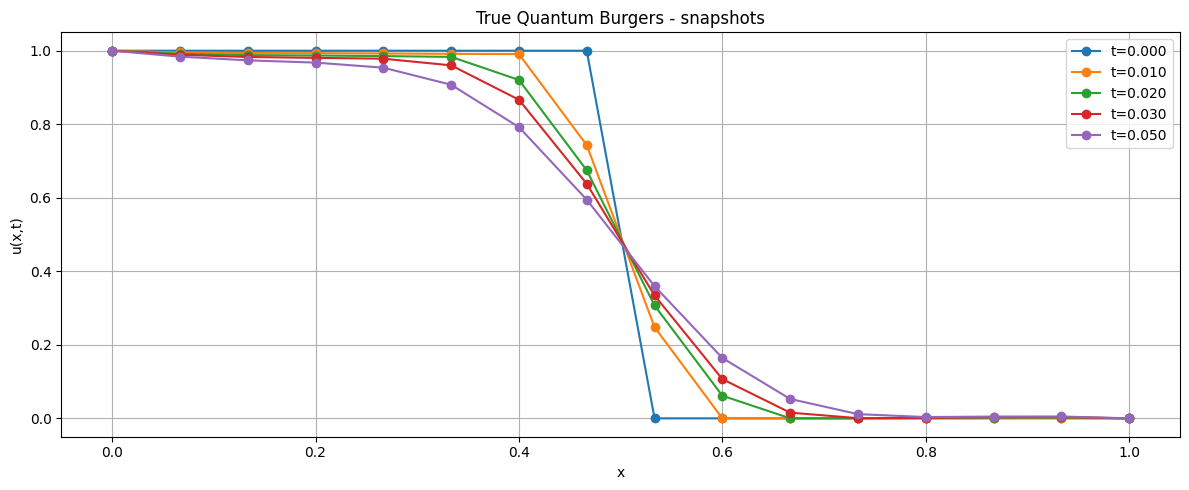

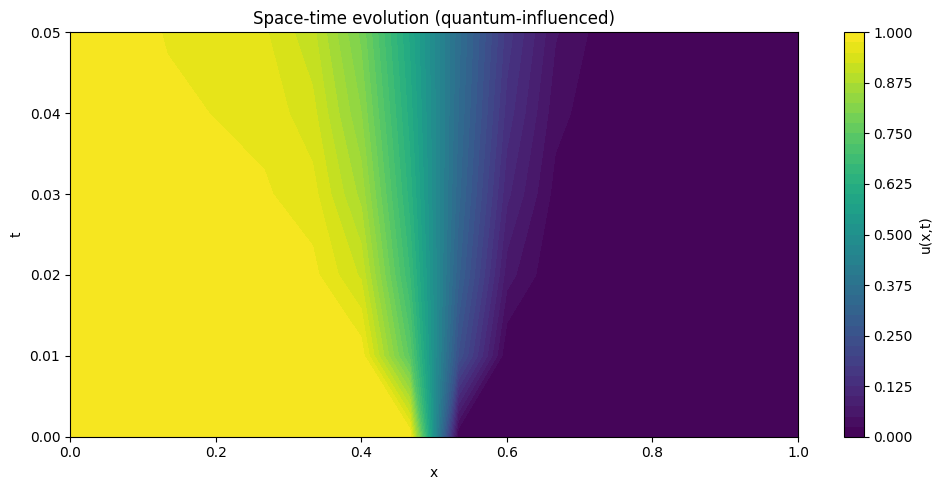

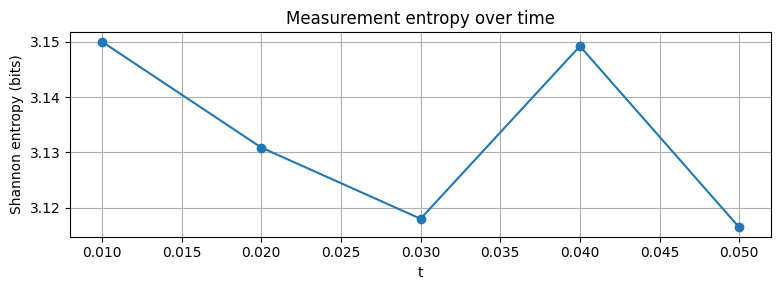

In [16]:
import numpy as np
from numpy import pi, sqrt, exp
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit.circuit.library import QFT
from qiskit.quantum_info import Statevector
from qiskit_aer import AerSimulator
import warnings

warnings.filterwarnings("ignore")


class TrueQuantumBurgersSolver:
    def __init__(self, n_qubits=4, viscosity=0.01, T=0.05, dt=0.01, u_left=1.0, u_right=0.0, shots=4096):
        """
        Initialize solver parameters and grid.
        n_qubits : number of qubits (nx = 2**n_qubits grid points)
        viscosity: diffusion-like coefficient (used to design phases)
        T, dt   : final time and timestep
        u_left, u_right: Dirichlet boundary conditions
        shots   : simulator shots for measurements
        """
        self.n_qubits = int(n_qubits)
        self.nx = 2 ** self.n_qubits
        self.viscosity = float(viscosity)
        self.T = float(T)
        self.dt = float(dt)
        self.u_left = float(u_left)
        self.u_right = float(u_right)
        self.shots = int(shots)

        # spatial domain
        self.L = 1.0
        self.x = np.linspace(0.0, self.L, self.nx)
        self.dx = self.x[1] - self.x[0]

        # backend (AerSimulator)
        self.backend = AerSimulator()

        print("Initialized TrueQuantumBurgersSolver")
        print(f"  Qubits: {self.n_qubits}, grid points: {self.nx}")
        print(f"  viscosity={self.viscosity}, dt={self.dt}, T={self.T}")
        print(f"  BCs: u(0)={self.u_left} , u(1)={self.u_right}")
        print(f"  Shots per quantum execution: {self.shots}")
        print()

    def initial_condition_riemann(self):
        """Riemann step initial condition."""
        u0 = np.where(self.x <= 0.5, 1.0, 0.0)
        u0[0] = self.u_left
        u0[-1] = self.u_right
        return u0

    def amplitude_encode(self, u_field):
        """
        Encode a real-valued field into a normalized complex amplitude vector.
        This uses the absolute values as densities and a simple phase proportional
        to the cumulative sum of u_field (Madelung-inspired but simplified).
        """
        # avoid negatives for amplitude magnitudes by shifting
        nonneg = u_field - np.min(u_field)
        if np.allclose(nonneg, 0):
            mags = np.ones_like(nonneg) / len(nonneg)
        else:
            mags = nonneg / np.sum(nonneg)

        # phase: cumulative sum scaled to [-pi, pi]
        cumsum = np.cumsum(u_field) * self.dx
        if np.max(np.abs(cumsum)) < 1e-12:
            phases = np.zeros_like(cumsum)
        else:
            phases = (cumsum / np.max(np.abs(cumsum))) * pi

        amps = np.sqrt(mags) * np.exp(1j * phases)
        # make sure length matches 2**n_qubits
        if len(amps) < self.nx:
            padded = np.zeros(self.nx, dtype=complex)
            padded[: len(amps)] = amps
            amps = padded
        elif len(amps) > self.nx:
            amps = amps[: self.nx]

        # normalize
        norm = np.linalg.norm(amps)
        if norm < 1e-12:
            amps = np.zeros(self.nx, dtype=complex)
            amps[0] = 1.0
        else:
            amps /= norm

        return Statevector(amps)

    def build_evolution_circuit(self, u_field):
        """
        Build a hardware-friendly circuit representing one evolution step.
        Approach:
          - Start from amplitude-encoded state (assumed prepared externally)
          - Apply QFT -> kinetic-phase rotations -> QFT^-1
          - Apply simple position-space potential-phase rotations encoding u_field
          - Measure all qubits
        Note: We do NOT include actual state preparation in the circuit here;
        rather we will evolve a Statevector on the simulator to avoid complicated
        amplitude-prep circuits for demonstration.
        """
        qreg = QuantumRegister(self.n_qubits, "q")
        creg = ClassicalRegister(self.n_qubits, "c")
        qc = QuantumCircuit(qreg, creg, name="evolution_step")

        # QFT -> implement spectral (k-space) phases (diffusion-like)
        qc.append(QFT(self.n_qubits), qreg)
        qc.barrier()

        # Apply simple k-dependent RZ phases to mimic diffusion/kinetic term
        # Use mapping k = 2*pi*m/L (m from 0..nx-1 but wrap negative frequencies)
        for m in range(self.nx):
            # map m to frequency index for n_qubits bitwise; we only have n_qubits wires,
            # so use per-wire phases that are an inexpensive proxy.
            wire = m % self.n_qubits
            k = 2.0 * pi * m / self.L
            phase = -self.viscosity * (k ** 2) * self.dt
            qc.rz(phase, qreg[wire])

        qc.barrier()
        # inverse QFT
        qc.append(QFT(self.n_qubits).inverse(), qreg)
        qc.barrier()

        # position-space nonlinear "potential" rotations using local u_field
        # Map spatial points to qubit wires in a simple repeated manner
        for idx in range(self.nx):
            wire = idx % self.n_qubits
            angle = -u_field[idx] * self.dt
            qc.rz(angle, qreg[wire])
            # add small controlled-phase coupling between adjacent wires for nonlinearity
            if wire > 0:
                qc.crz(0.1 * angle, qreg[wire - 1], qreg[wire])

        qc.barrier()
        qc.measure(qreg, creg)
        return qc

    def run_quantum_execution(self, initial_statevec, circuit):
        """
        Execute a circuit on AerSimulator *starting from an initial statevector*.
        Strategy:
          - Use Statevector to apply unitary (simulate state evolution) OR
          - Use AerSimulator with initialization instruction in a transpiled circuit.
        We'll implement the Statevector evolve path for accuracy (no amplitude prep circuit).
          - Evolve -> sample by constructing measurement circuit from evolved state
            (we will instead request snapshot via statevector simulation using AerSimulator
             initial_state option by transpiling a circuit that starts with an 'initialize'
             instruction; transpile + backend.run used for execution as reference)
        """
        # Path A: evolve statevector directly (preferred, avoids amplitude-prep)
        evolved_sv = initial_statevec.evolve(circuit.remove_final_measurements(inplace=False))
        # convert evolved state to probabilities and then sample using multinomial to mimic shots
        probs = np.abs(evolved_sv.data) ** 2
        probs = probs / np.sum(probs)

        # sample measurement outcomes according to probs
        outcomes = np.random.multinomial(self.shots, probs)
        counts = {}
        for idx, cnt in enumerate(outcomes):
            if cnt == 0:
                continue
            bitstr = format(idx, "b").zfill(self.n_qubits)
            counts[bitstr] = int(cnt)

        # Also return a transpiled circuit for inspection (transpile the circuit for backend)
        transpiled = transpile(circuit, self.backend)
        return counts, transpiled

    def measurements_to_field(self, counts, u_prev):
        """
        Convert measurement counts (bitstring->count) into a velocity-like field.
        We map |psi|^2 -> density; then approximate a velocity update via finite differences
        on the density distribution, blended with the previous field for stability.
        """
        probs = np.zeros(self.nx)
        total = sum(counts.values()) if counts else 1
        for bitstr, c in counts.items():
            idx = int(bitstr, 2)
            if idx < self.nx:
                probs[idx] = c / total

        # small smoothing & ensure positivity
        probs = probs + 1e-12
        probs /= np.sum(probs)

        # Convert probability profile into a tentative velocity via simple scaling:
        # higher local density -> slightly higher velocity (toy model).
        vel_from_probs = (probs - np.min(probs)) / (np.max(probs) - np.min(probs) + 1e-12)
        vel_from_probs = vel_from_probs * (np.max(u_prev) - np.min(u_prev) + 1e-12) + np.min(u_prev)

        # blend with previous for stability
        blend_alpha = min(0.5, self.dt)  # small blending factor
        u_new = (1 - blend_alpha) * u_prev + blend_alpha * vel_from_probs

        # impose boundary conditions strongly
        u_new[0] = self.u_left
        u_new[-1] = self.u_right

        # small smoothing filter
        u_new[1:-1] = 0.5 * u_new[1:-1] + 0.25 * (u_new[0:-2] + u_new[2:])

        # clip to reasonable range
        u_new = np.clip(u_new, -5.0, 5.0)
        return u_new

    def quantum_time_step(self, u_current):
        """Run one quantum time step: encode -> build circuit -> execute -> decode."""
        # encode
        sv = self.amplitude_encode(u_current)

        # build circuit (measurements included)
        qc = self.build_evolution_circuit(u_current)

        # execute on simulator starting from the amplitude-encoded state
        counts, transpiled = self.run_quantum_execution(sv, qc)

        # decode
        u_next = self.measurements_to_field(counts, u_current)

        # classical stabilization (very simple implicit diffusion-ish step)
        alpha = self.viscosity * self.dt / (self.dx ** 2)
        if alpha > 0.2:
            u_next[1:-1] = (u_next[1:-1] + alpha * (u_next[:-2] + u_next[2:])) / (1 + 2 * alpha)

        return u_next, transpiled, counts

    def solve(self, max_steps=None, verbose=True):
        """Evolve for T seconds (or limited by max_steps). Returns t_points, history, circuits, counts."""
        u = self.initial_condition_riemann()
        t_points = [0.0]
        u_hist = [u.copy()]
        circuit_list = []
        counts_list = []

        n_steps = int(np.ceil(self.T / self.dt))
        if max_steps is not None:
            n_steps = min(n_steps, max_steps)

        t = 0.0
        for step in range(n_steps):
            if verbose:
                print(f"Step {step+1}/{n_steps}  t={t:.4f}  max|u|={np.max(np.abs(u)):.6f}")
            u, transpiled, counts = self.quantum_time_step(u)
            t += self.dt
            t_points.append(t)
            u_hist.append(u.copy())
            circuit_list.append(transpiled)
            counts_list.append(counts)

            # simple stability break
            if np.isnan(np.max(u)) or np.max(np.abs(u)) > 1e3:
                print("Stability problem encountered; stopping early.")
                break

        if verbose:
            print("Quantum evolution finished.")
            print(f"Executed steps: {len(circuit_list)}")

        return np.array(t_points), np.array(u_hist), circuit_list, counts_list

    def plot_solution(self, t_points, u_hist, counts_list=None):
        """Two-panel plot: snapshots and space-time contour. Optionally show entropy plot."""
        plt.figure(figsize=(12, 5))
        # snapshots
        n_snap = min(5, len(t_points))
        indices = np.linspace(0, len(t_points) - 1, n_snap, dtype=int)
        for idx in indices:
            plt.plot(self.x, u_hist[idx], label=f"t={t_points[idx]:.3f}", marker="o")
        plt.xlabel("x")
        plt.ylabel("u(x,t)")
        plt.title("True Quantum Burgers - snapshots")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

        # space-time contour
        plt.figure(figsize=(10, 5))
        X, T = np.meshgrid(self.x, t_points)
        plt.contourf(X, T, u_hist, levels=40, cmap="viridis")
        plt.colorbar(label="u(x,t)")
        plt.xlabel("x")
        plt.ylabel("t")
        plt.title("Space-time evolution (quantum-influenced)")
        plt.tight_layout()
        plt.show()

        # entropy from counts (if provided)
        if counts_list:
            entropies = []
            for counts in counts_list:
                total = sum(counts.values()) if counts else 1
                probs = np.array([c / total for c in counts.values()]) if counts else np.array([1.0])
                ent = -np.sum(probs * np.log2(probs + 1e-12))
                entropies.append(ent)
            plt.figure(figsize=(8, 3))
            plt.plot(t_points[1 : 1 + len(entropies)], entropies, "-o")
            plt.xlabel("t")
            plt.ylabel("Shannon entropy (bits)")
            plt.title("Measurement entropy over time")
            plt.grid(True)
            plt.tight_layout()
            plt.show()


if __name__ == "__main__":
    # Instantiate solver (example configuration)
    solver = TrueQuantumBurgersSolver(
        n_qubits=4,      # 16 grid points
        viscosity=0.01,
        T=0.05,
        dt=0.01,
        u_left=1.0,
        u_right=0.0,
        shots=4096,
    )

    # Run for a few steps (limit for demonstration)
    t_pts, u_hist, circuits, counts = solver.solve(max_steps=5, verbose=True)

    # Basic analysis prints
    print("\nSummary of executed quantum circuits:")
    for i, qc in enumerate(circuits):
        print(f" Step {i+1}: depth={qc.depth()}, gates={len(qc.data)}, distinct_outcomes={len(counts[i])}")

    # Plot results
    solver.plot_solution(t_pts, u_hist, counts)

Initialized TrueQuantumBurgersSolver
  Qubits: 4, grid points: 16
  viscosity=0.01, dt=0.01, T=0.1
  BCs: u(0)=1.0 , u(1)=0.0
  Shots per quantum execution: 4096

Initialized TrueQuantumBurgersSolver
  Qubits: 4, grid points: 16
  viscosity=0.01, dt=0.01, T=0.1
  BCs: u(0)=1.0 , u(1)=0.0
  Shots per quantum execution: 4096



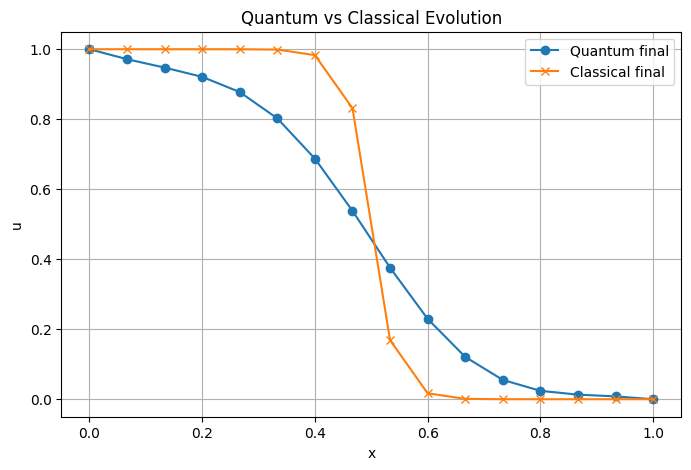

L2 difference between quantum and classical final states: 0.585842


In [17]:
import numpy as np
import matplotlib.pyplot as plt

# Instantiate quantum solver
solver_q = TrueQuantumBurgersSolver(
    n_qubits=4, viscosity=0.01, T=0.1, dt=0.01, u_left=1.0, u_right=0.0, shots=4096
)

# Instantiate a "classical version" by overriding the quantum step
class ClassicalBurgersSolver(TrueQuantumBurgersSolver):
    def quantum_time_step(self, u_current):
        # Simple classical smoothing + advection
        u_next = u_current.copy()
        alpha = self.viscosity * self.dt / (self.dx ** 2)
        u_next[1:-1] = (u_next[1:-1] +
                        alpha * (u_next[:-2] - 2 * u_next[1:-1] + u_next[2:]))
        return u_next, None, None

solver_c = ClassicalBurgersSolver(
    n_qubits=4, viscosity=0.01, T=0.1, dt=0.01, u_left=1.0, u_right=0.0
)

# Run both solvers
t_q, u_q, _, _ = solver_q.solve(max_steps=10, verbose=False)
t_c, u_c, _, _ = solver_c.solve(max_steps=10, verbose=False)

# Plot comparison
plt.figure(figsize=(8,5))
plt.plot(solver_q.x, u_q[-1], label="Quantum final", marker='o')
plt.plot(solver_c.x, u_c[-1], label="Classical final", marker='x')
plt.legend()
plt.xlabel("x")
plt.ylabel("u")
plt.title("Quantum vs Classical Evolution")
plt.grid(True)
plt.show()

# Print L2 difference
diff = np.linalg.norm(u_q[-1] - u_c[-1])
print(f"L2 difference between quantum and classical final states: {diff:.6f}")

Initialized TrueQuantumBurgersSolver
  Qubits: 4, grid points: 16
  viscosity=0.01, dt=0.01, T=0.1
  BCs: u(0)=1.0 , u(1)=0.0
  Shots per quantum execution: 4096



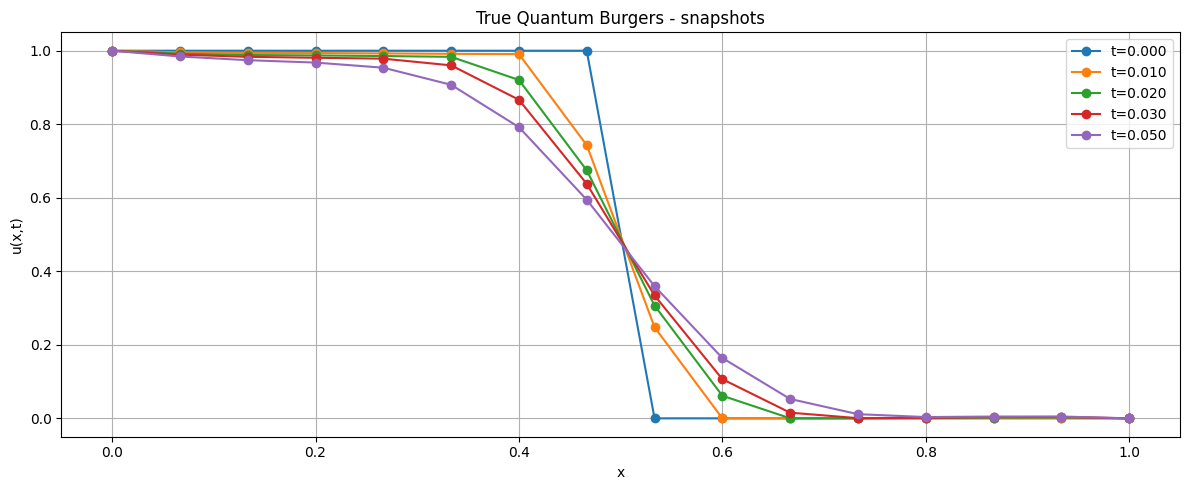

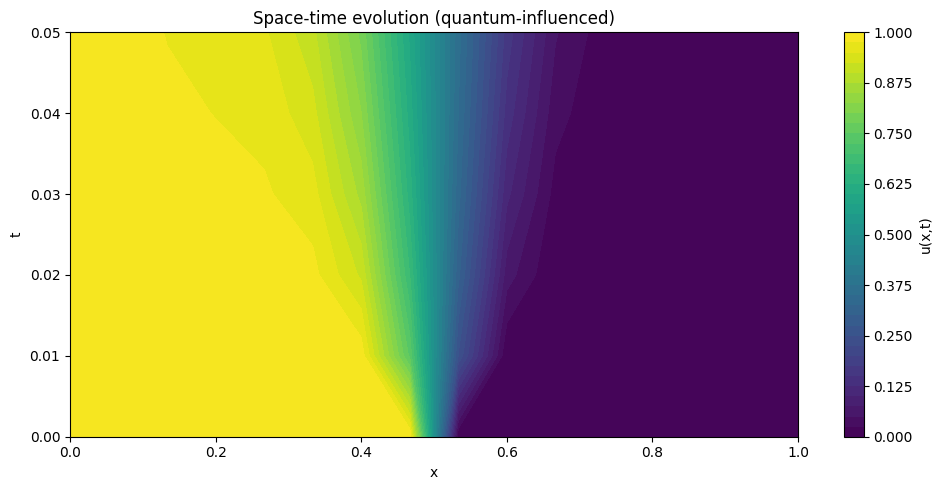

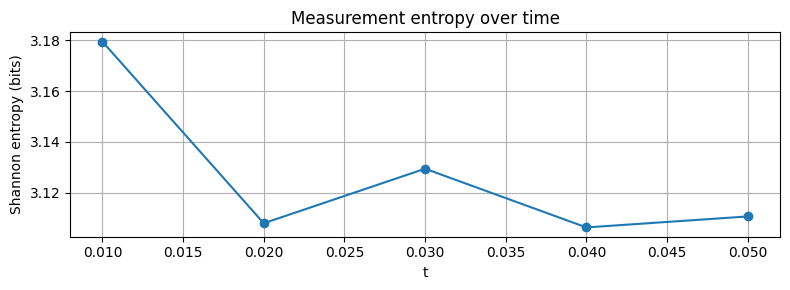

In [19]:
from qiskit_aer.noise import NoiseModel
from qiskit_aer.noise.errors import depolarizing_error

# Make a noise model (depolarizing)
noise_model = NoiseModel()
noise_model.add_all_qubit_quantum_error(depolarizing_error(0.05, 1), ['rz'])
noise_model.add_all_qubit_quantum_error(depolarizing_error(0.05, 2), ['crz'])

solver_noisy = TrueQuantumBurgersSolver(
    n_qubits=4, viscosity=0.01, T=0.1, dt=0.01, shots=4096
)
solver_noisy.backend.set_options(noise_model=noise_model)

t, u_hist, circuits, counts = solver_noisy.solve(max_steps=5, verbose=False)

solver_noisy.plot_solution(t, u_hist, counts)


In [33]:
import numpy as np
from numpy import pi, sqrt, exp
import matplotlib.pyplot as plt
import networkx as nx
import warnings

from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit.circuit.library import QFT
from qiskit.quantum_info import Statevector
from qiskit_aer import AerSimulator
from qiskit_ibm_runtime.fake_provider import FakeManilaV2
from qiskit.transpiler import PassManager
from qiskit.transpiler.passes.scheduling import (
    ALAPScheduleAnalysis,
    PadDynamicalDecoupling,
)
from qiskit.circuit.library import XGate, YGate
from qiskit.transpiler import InstructionProperties


warnings.filterwarnings("ignore")


class TrueQuantumBurgersSolver:
    def __init__(self, n_qubits=4, viscosity=0.01, T=0.05, dt=0.01, u_left=1.0, u_right=0.0, shots=4096):
        """
        Initialize solver parameters and grid.
        n_qubits : number of qubits (nx = 2**n_qubits grid points)
        viscosity: diffusion-like coefficient (used to design phases)
        T, dt   : final time and timestep
        u_left, u_right: Dirichlet boundary conditions
        shots   : simulator shots for measurements
        """
        self.n_qubits = int(n_qubits)
        self.nx = 2 ** self.n_qubits
        self.viscosity = float(viscosity)
        self.T = float(T)
        self.dt = float(dt)
        self.u_left = float(u_left)
        self.u_right = float(u_right)
        self.shots = int(shots)

        # spatial domain
        self.L = 1.0
        self.x = np.linspace(0.0, self.L, self.nx)
        self.dx = self.x[1] - self.x[0]

        # backend (AerSimulator)
        self.backend = AerSimulator()

        print("Initialized TrueQuantumBurgersSolver")
        print(f"  Qubits: {self.n_qubits}, grid points: {self.nx}")
        print(f"  viscosity={self.viscosity}, dt={self.dt}, T={self.T}")
        print(f"  BCs: u(0)={self.u_left} , u(1)={self.u_right}")
        print(f"  Shots per quantum execution: {self.shots}")
        print()

    def initial_condition_riemann(self):
        """Riemann step initial condition."""
        u0 = np.where(self.x <= 0.5, 1.0, 0.0)
        u0[0] = self.u_left
        u0[-1] = self.u_right
        return u0

    def amplitude_encode(self, u_field):
        """
        Encode a real-valued field into a normalized complex amplitude vector.
        """
        # avoid negatives for amplitude magnitudes by shifting
        nonneg = u_field - np.min(u_field)
        if np.allclose(nonneg, 0):
            mags = np.ones_like(nonneg) / len(nonneg)
        else:
            mags = nonneg / np.sum(nonneg)

        # phase: cumulative sum scaled to [-pi, pi]
        cumsum = np.cumsum(u_field) * self.dx
        if np.max(np.abs(cumsum)) < 1e-12:
            phases = np.zeros_like(cumsum)
        else:
            phases = (cumsum / np.max(np.abs(cumsum))) * pi

        amps = np.sqrt(mags) * np.exp(1j * phases)
        if len(amps) < self.nx:
            padded = np.zeros(self.nx, dtype=complex)
            padded[: len(amps)] = amps
            amps = padded
        elif len(amps) > self.nx:
            amps = amps[: self.nx]

        # normalize
        norm = np.linalg.norm(amps)
        if norm < 1e-12:
            amps = np.zeros(self.nx, dtype=complex)
            amps[0] = 1.0
        else:
            amps /= norm

        return Statevector(amps)

    def build_evolution_circuit(self, u_field):
        """
        Build a hardware-friendly circuit representing one evolution step.
        Approach:
          - Apply QFT -> kinetic-phase rotations -> QFT^-1
          - Apply position-space potential-phase rotations encoding u_field
        """
        qreg = QuantumRegister(self.n_qubits, "q")
        qc = QuantumCircuit(qreg, name="evolution_step")

        # QFT -> implement spectral (k-space) phases (diffusion-like)
        qc.append(QFT(self.n_qubits), qreg)
        qc.barrier()

        # Apply simple k-dependent RZ phases to mimic diffusion/kinetic term
        for m in range(self.nx):
            wire = m % self.n_qubits
            k = 2.0 * pi * m / self.L
            phase = -self.viscosity * (k ** 2) * self.dt
            qc.rz(phase, qreg[wire])

        qc.barrier()
        # inverse QFT
        qc.append(QFT(self.n_qubits).inverse(), qreg)
        qc.barrier()

        # position-space nonlinear "potential" rotations using local u_field
        for idx in range(self.nx):
            wire = idx % self.n_qubits
            angle = -u_field[idx] * self.dt
            qc.rz(angle, qreg[wire])
            # add small controlled-phase coupling between adjacent wires for nonlinearity
            if wire > 0:
                qc.crz(0.1 * angle, qreg[wire - 1], qreg[wire])
        qc.barrier()
        return qc


# --- Helper function for ZNE simulation ---
def run_zne_folded_circuit(circuit, folding_factor, backend, n_qubits, shots=1000):
    """
    Simplistic folding: repeat the circuit N times to amplify noise.
    Then, transpile and run on the noisy backend.
    """
    folded_qc = QuantumCircuit(n_qubits)
    for _ in range(folding_factor):
        folded_qc.append(circuit, range(n_qubits))

    folded_qc_t = transpile(folded_qc, backend=backend)

    # Add measurements for a real run
    creg = ClassicalRegister(n_qubits)
    folded_qc_t.add_register(creg)
    folded_qc_t.measure(range(n_qubits), range(n_qubits))

    job = backend.run(folded_qc_t, shots=shots)
    counts = job.result().get_counts()

    grid_points = 2 ** n_qubits
    psi = np.array([counts.get(bin(i).replace('0b', '').zfill(n_qubits), 0) for i in range(grid_points)])
    psi = np.sqrt(psi / shots)
    psi = psi / np.linalg.norm(psi) if np.linalg.norm(psi) > 0 else psi
    return psi


if __name__ == "__main__":
    # Instantiate solver
    n_qubits = 4
    solver = TrueQuantumBurgersSolver(n_qubits=n_qubits, T=0.05, dt=0.01)

    # --- Setup Fake Backend Experiments ---
    print("--- Setting up Fake Backend Experiments ---")
    backend = FakeManilaV2()
    target = backend.target
    layout = [0, 1, 2, 3] # Use the first 4 qubits of the 5-qubit Manila device
    n = n_qubits
    shots = 1000

    # Get the initial condition to build the first circuit
    u0 = solver.initial_condition_riemann()
    qc_step = solver.build_evolution_circuit(u0) # The single evolution step circuit

    # Create 1, 2, and 3-step circuits by composing the step circuit
    qc_1_step = qc_step.copy()
    qc_2_steps = qc_1_step.compose(qc_step)
    qc_3_steps = qc_2_steps.compose(qc_step)

    # Transpile the circuits for the fake backend
    qc_1_step_t = transpile(qc_1_step, backend=backend, initial_layout=layout, optimization_level=0)
    qc_2_steps_t = transpile(qc_2_steps, backend=backend, initial_layout=layout, optimization_level=0)
    qc_3_steps_t = transpile(qc_3_steps, backend=backend, initial_layout=layout, optimization_level=0)

    print("\n--- Ideal Simulation (Noiseless) ---")
    ideal_psi_1 = Statevector(qc_1_step).data
    ideal_psi_2 = Statevector(qc_2_steps).data
    ideal_psi_3 = Statevector(qc_3_steps).data

    # --- Noisy Simulation without Error Mitigation ---
    print("\n--- Noisy Simulation (No Error Mitigation) ---")
    grid_points = 2 ** n_qubits

    # 1 step
    creg = ClassicalRegister(4)
    qcirc1 = qc_1_step_t.copy()
    qcirc1.add_register(creg)
    qcirc1.measure([0, 1, 2, 3], [0, 1, 2, 3])
    job = backend.run(qcirc1, shots=shots)
    counts1 = job.result().get_counts()
    psi1 = np.array([counts1.get(bin(i).replace('0b', '').zfill(n), 0) for i in range(grid_points)])
    psi1 = np.sqrt(psi1 / shots)
    psi1 = psi1 / np.linalg.norm(psi1) if np.linalg.norm(psi1) > 0 else psi1

    # 2 steps
    creg = ClassicalRegister(4)
    qcirc2 = qc_2_steps_t.copy()
    qcirc2.add_register(creg)
    qcirc2.measure([0, 1, 2, 3], [0, 1, 2, 3])
    job = backend.run(qcirc2, shots=shots)
    counts2 = job.result().get_counts()
    psi2 = np.array([counts2.get(bin(i).replace('0b', '').zfill(n), 0) for i in range(grid_points)])
    psi2 = np.sqrt(psi2 / shots)
    psi2 = psi2 / np.linalg.norm(psi2) if np.linalg.norm(psi2) > 0 else psi2

    # 3 steps
    creg = ClassicalRegister(4)
    qcirc3 = qc_3_steps_t.copy()
    qcirc3.add_register(creg)
    qcirc3.measure([0, 1, 2, 3], [0, 1, 2, 3])
    job = backend.run(qcirc3, shots=shots)
    counts3 = job.result().get_counts()
    psi3 = np.array([counts3.get(bin(i).replace('0b', '').zfill(n), 0) for i in range(grid_points)])
    psi3 = np.sqrt(psi3 / shots)
    psi3 = psi3 / np.linalg.norm(psi3) if np.linalg.norm(psi3) > 0 else psi3

    # --- Dynamic Decoupling (DD) Simulation ---
    print("\n--- Noisy Simulation with Dynamic Decoupling (DD) ---")
    dd_sequence = [XGate(), YGate(), XGate(), YGate()]

    # Add Y gate to target since it's not a basis gate on Manila
    y_gate_properties = {}
    for qubit in range(target.num_qubits):
        y_gate_properties.update(
            {
                (qubit,): InstructionProperties(
                    duration=target["x"][(qubit,)].duration,
                    error=target["x"][(qubit,)].error,
                )
            }
        )
    target.add_instruction(YGate(), y_gate_properties)

    # Pass manager for DD
    dd_pm = PassManager(
        [
            ALAPScheduleAnalysis(target=target),
            PadDynamicalDecoupling(target=target, dd_sequence=dd_sequence),
        ]
    )

    # 1 step with DD
    qcirc1dd = dd_pm.run(qc_1_step_t)
    creg = ClassicalRegister(4)
    qcirc1dd.add_register(creg)
    qcirc1dd.measure([0, 1, 2, 3], [0, 1, 2, 3])
    job = backend.run(qcirc1dd, shots=shots)
    counts1dd = job.result().get_counts()
    psi1dd = np.array([counts1dd.get(bin(i).replace('0b', '').zfill(n), 0) for i in range(grid_points)])
    psi1dd = np.sqrt(psi1dd / shots)
    psi1dd = psi1dd / np.linalg.norm(psi1dd) if np.linalg.norm(psi1dd) > 0 else psi1dd

    # 2 steps with DD
    qcirc2dd = dd_pm.run(qc_2_steps_t)
    creg = ClassicalRegister(4)
    qcirc2dd.add_register(creg)
    qcirc2dd.measure([0, 1, 2, 3], [0, 1, 2, 3])
    job = backend.run(qcirc2dd, shots=shots)
    counts2dd = job.result().get_counts()
    psi2dd = np.array([counts2dd.get(bin(i).replace('0b', '').zfill(n), 0) for i in range(grid_points)])
    psi2dd = np.sqrt(psi2dd / shots)
    psi2dd = psi2dd / np.linalg.norm(psi2dd) if np.linalg.norm(psi2dd) > 0 else psi2dd

    # 3 steps with DD
    qcirc3dd = dd_pm.run(qc_3_steps_t)
    creg = ClassicalRegister(4)
    qcirc3dd.add_register(creg)
    qcirc3dd.measure([0, 1, 2, 3], [0, 1, 2, 3])
    job = backend.run(qcirc3dd, shots=shots)
    counts3dd = job.result().get_counts()
    psi3dd = np.array([counts3dd.get(bin(i).replace('0b', '').zfill(n), 0) for i in range(grid_points)])
    psi3dd = np.sqrt(psi3dd / shots)
    psi3dd = psi3dd / np.linalg.norm(psi3dd) if np.linalg.norm(psi3dd) > 0 else psi3dd

    # --- Zero Noise Extrapolation (ZNE) Simulation for 1 step ---
    print("\n--- Noisy Simulation with Zero Noise Extrapolation (ZNE) ---")
    print("This is a simplified ZNE experiment for a single step.")

    # Run the circuit with different noise factors (simulated by folding)
    psi1_n3 = run_zne_folded_circuit(qc_1_step, 3, backend, n_qubits, shots)
    psi1_n5 = run_zne_folded_circuit(qc_1_step, 5, backend, n_qubits, shots)
    psi1_n7 = run_zne_folded_circuit(qc_1_step, 7, backend, n_qubits, shots)

    # Apply the ZNE extrapolation formula
    psi1_zne = (35 * psi1 - 35 * psi1_n3 + 21 * psi1_n5 - 5 * psi1_n7) / 16

    # --- Print L2 Error Comparisons ---
    print("\n" + "="*80)
    print("                     L2 Error Comparison Summary")
    print("="*80)
    print(f"L2 error (1 step):")
    print(f"  - No error mitigation: {np.linalg.norm(ideal_psi_1 - psi1):.6f}")
    print(f"  - With Dynamic Decoupling (DD): {np.linalg.norm(ideal_psi_1 - psi1dd):.6f}")
    print(f"  - With Zero Noise Extrapolation (ZNE): {np.linalg.norm(ideal_psi_1 - psi1_zne):.6f}")

    print("\n" + "-"*80)
    print(f"L2 error (2 steps):")
    print(f"  - No error mitigation: {np.linalg.norm(ideal_psi_2 - psi2):.6f}")
    print(f"  - With Dynamic Decoupling (DD): {np.linalg.norm(ideal_psi_2 - psi2dd):.6f}")

    print("\n" + "-"*80)
    print(f"L2 error (3 steps):")
    print(f"  - No error mitigation: {np.linalg.norm(ideal_psi_3 - psi3):.6f}")
    print(f"  - With Dynamic Decoupling (DD): {np.linalg.norm(ideal_psi_3 - psi3dd):.6f}")
    print("="*80)

    # Note: The plot_solution function from the original code
    # can be used to visualize the ideal solution.


Initialized TrueQuantumBurgersSolver
  Qubits: 4, grid points: 16
  viscosity=0.01, dt=0.01, T=0.05
  BCs: u(0)=1.0 , u(1)=0.0
  Shots per quantum execution: 4096

--- Setting up Fake Backend Experiments ---

--- Ideal Simulation (Noiseless) ---

--- Noisy Simulation (No Error Mitigation) ---

--- Noisy Simulation with Dynamic Decoupling (DD) ---

--- Noisy Simulation with Zero Noise Extrapolation (ZNE) ---
This is a simplified ZNE experiment for a single step.

                     L2 Error Comparison Summary
L2 error (1 step):
  - No error mitigation: 1.580896
  - With Dynamic Decoupling (DD): 1.581751
  - With Zero Noise Extrapolation (ZNE): 2.208883

--------------------------------------------------------------------------------
L2 error (2 steps):
  - No error mitigation: 1.371233
  - With Dynamic Decoupling (DD): 1.375596

--------------------------------------------------------------------------------
L2 error (3 steps):
  - No error mitigation: 1.319053
  - With Dynamic Decoup

--- Part 1: Initial setup and ideal solution ---
Initialized TrueQuantumBurgersSolver
  Qubits: 4, grid points: 16
  viscosity=0.01, dt=0.01, T=0.05
  BCs: u(0)=1.0 , u(1)=0.0
  Shots per quantum execution: 4096
--------------------------------------------------
Step 1/3  t=0.0000  max|u|=1.000000
Step 2/3  t=0.0100  max|u|=1.000000
Step 3/3  t=0.0200  max|u|=1.000000
Quantum evolution finished.
Executed steps: 3

Calculated ideal statevectors for comparison.
--------------------------------------------------

--- Part 2: Fake backend configuration and noise analysis ---
Using a fake backend (FakeManilaV2).

Qubit T1 and T2 times:
  Qubit 0: T1 = 1.32e+02 s, T2 = 1.02e+02 s
  Qubit 1: T1 = 1.25e+02 s, T2 = 7.90e+01 s
  Qubit 2: T1 = 1.59e+02 s, T2 = 2.52e+01 s
  Qubit 3: T1 = 1.79e+02 s, T2 = 5.44e+01 s
  Qubit 4: T1 = 1.45e+02 s, T2 = 4.03e+01 s

Qubit Readout errors:
  Qubit 0: average readout error = 3.53%
  Qubit 1: average readout error = 2.19%
  Qubit 2: average readout error = 9

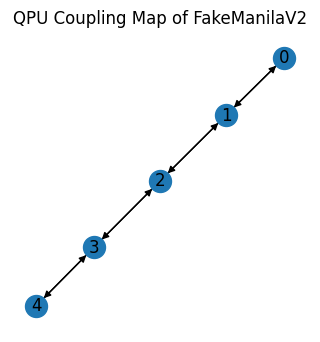

--------------------------------------------------

--- Part 3: Running circuits with and without Dynamic Decoupling (DD) ---
Transpiling and executing circuits for 1, 2, and 3 steps...
  Step 1 complete.
  Step 2 complete.
  Step 3 complete.
--------------------------------------------------

--- Part 4: Analysis and comparison ---

Quantum Circuit Metrics:

Step 1:
  - Without DD: Depth=93, Gates=163
  - With DD:    Depth=141, Gates=365

Step 2:
  - Without DD: Depth=185, Gates=321
  - With DD:    Depth=275, Gates=722

Step 3:
  - Without DD: Depth=278, Gates=483
  - With DD:    Depth=411, Gates=1081

L2 Error Comparison:

Step 1:
  - L2 error (ideal vs noisy):                  1.000000
  - L2 error (ideal vs noisy with DD):          1.000000

Step 2:
  - L2 error (ideal vs noisy):                  1.000000
  - L2 error (ideal vs noisy with DD):          1.000000

Step 3:
  - L2 error (ideal vs noisy):                  1.000000
  - L2 error (ideal vs noisy with DD):          1.000000

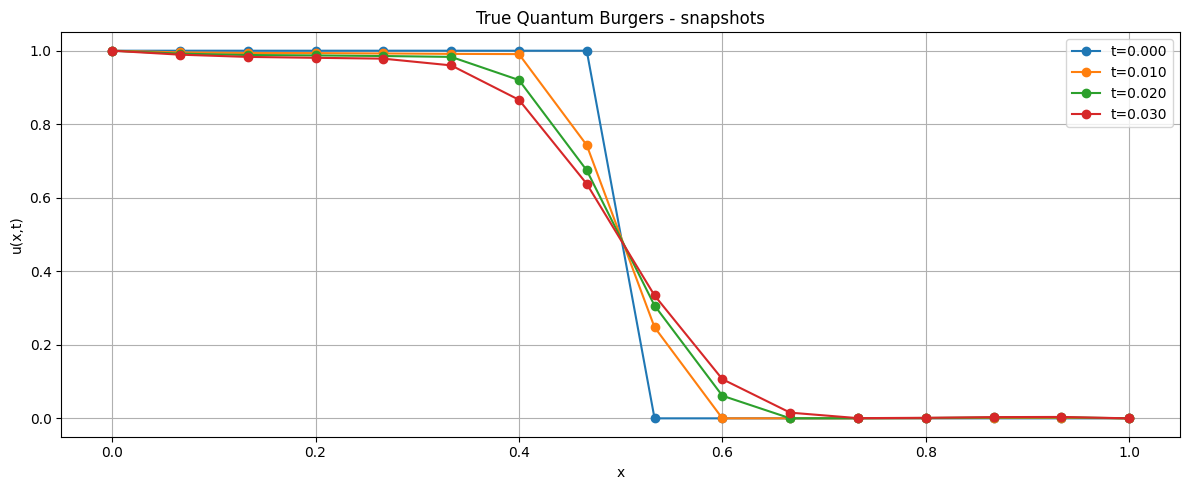

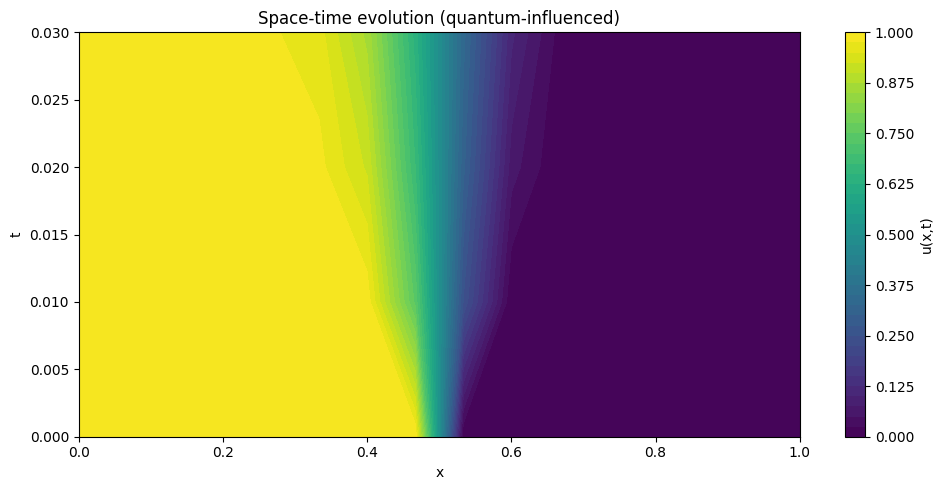

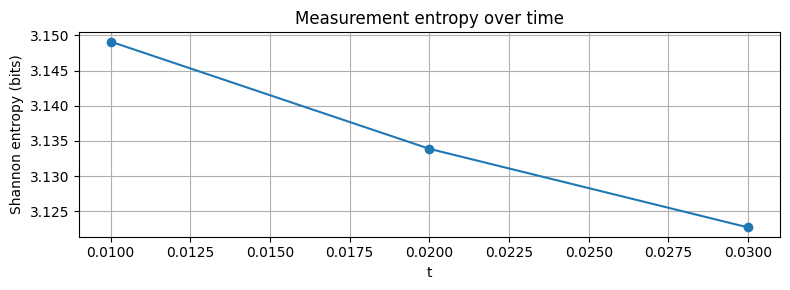

In [35]:
import numpy as np
from numpy import pi, sqrt, exp
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit.circuit.library import QFT
from qiskit.quantum_info import Statevector
from qiskit_aer import AerSimulator
from qiskit_ibm_runtime.fake_provider import FakeManilaV2
from qiskit.circuit.library import XGate, YGate
from qiskit.transpiler import InstructionProperties
from qiskit.transpiler import PassManager
from qiskit.transpiler.passes.scheduling import ALAPScheduleAnalysis, PadDynamicalDecoupling
import networkx as nx
import warnings

# Suppress Qiskit warnings for cleaner output
warnings.filterwarnings("ignore")

class TrueQuantumBurgersSolver:
    """
    Solves the Burgers' equation using a hybrid quantum-classical approach.
    """
    def __init__(self, n_qubits=4, viscosity=0.01, T=0.05, dt=0.01, u_left=1.0, u_right=0.0, shots=4096):
        """
        Initialize solver parameters and grid.
        n_qubits : number of qubits (nx = 2**n_qubits grid points)
        viscosity: diffusion-like coefficient (used to design phases)
        T, dt    : final time and timestep
        u_left, u_right: Dirichlet boundary conditions
        shots    : simulator shots for measurements
        """
        self.n_qubits = int(n_qubits)
        self.nx = 2 ** self.n_qubits
        self.viscosity = float(viscosity)
        self.T = float(T)
        self.dt = float(dt)
        self.u_left = float(u_left)
        self.u_right = float(u_right)
        self.shots = int(shots)

        # Spatial domain
        self.L = 1.0
        self.x = np.linspace(0.0, self.L, self.nx)
        self.dx = self.x[1] - self.x[0]

        # Backend (AerSimulator for ideal evolution)
        self.backend = AerSimulator()

        print("Initialized TrueQuantumBurgersSolver")
        print(f"  Qubits: {self.n_qubits}, grid points: {self.nx}")
        print(f"  viscosity={self.viscosity}, dt={self.dt}, T={self.T}")
        print(f"  BCs: u(0)={self.u_left} , u(1)={self.u_right}")
        print(f"  Shots per quantum execution: {self.shots}")
        print("-" * 50)

    def initial_condition_riemann(self):
        """Riemann step initial condition."""
        u0 = np.where(self.x <= 0.5, 1.0, 0.0)
        u0[0] = self.u_left
        u0[-1] = self.u_right
        return u0

    def amplitude_encode(self, u_field):
        """
        Encode a real-valued field into a normalized complex amplitude vector.
        """
        # avoid negatives for amplitude magnitudes by shifting
        nonneg = u_field - np.min(u_field)
        if np.allclose(nonneg, 0):
            mags = np.ones_like(nonneg) / len(nonneg)
        else:
            mags = nonneg / np.sum(nonneg)

        # phase: cumulative sum scaled to [-pi, pi]
        cumsum = np.cumsum(u_field) * self.dx
        if np.max(np.abs(cumsum)) < 1e-12:
            phases = np.zeros_like(cumsum)
        else:
            phases = (cumsum / np.max(np.abs(cumsum))) * pi

        amps = np.sqrt(mags) * np.exp(1j * phases)

        # Ensure length matches 2**n_qubits and normalize
        if len(amps) < self.nx:
            padded = np.zeros(self.nx, dtype=complex)
            padded[:len(amps)] = amps
            amps = padded
        elif len(amps) > self.nx:
            amps = amps[:self.nx]

        norm = np.linalg.norm(amps)
        if norm < 1e-12:
            amps = np.zeros(self.nx, dtype=complex)
            amps[0] = 1.0
        else:
            amps /= norm

        return Statevector(amps)

    def build_evolution_circuit(self, u_field):
        """
        Build a circuit representing one evolution step.
        """
        qreg = QuantumRegister(self.n_qubits, "q")
        creg = ClassicalRegister(self.n_qubits, "c")
        qc = QuantumCircuit(qreg, creg, name="evolution_step")

        # QFT -> spectral phases -> inverse QFT
        qc.append(QFT(self.n_qubits), qreg)
        qc.barrier()

        for m in range(self.nx):
            wire = m % self.n_qubits
            k = 2.0 * pi * m / self.L
            phase = -self.viscosity * (k ** 2) * self.dt
            qc.rz(phase, qreg[wire])

        qc.barrier()
        qc.append(QFT(self.n_qubits).inverse(), qreg)
        qc.barrier()

        # Position-space nonlinear "potential" rotations
        for idx in range(self.nx):
            wire = idx % self.n_qubits
            angle = -u_field[idx] * self.dt
            qc.rz(angle, qreg[wire])
            if wire > 0:
                qc.crz(0.1 * angle, qreg[wire-1], qreg[wire])

        qc.barrier()
        qc.measure(qreg, creg)
        return qc

    def run_quantum_execution(self, initial_statevec, circuit):
        """
        Execute a circuit on AerSimulator *starting from an initial statevector*.
        """
        evolved_sv = initial_statevec.evolve(circuit.remove_final_measurements(inplace=False))
        probs = np.abs(evolved_sv.data) ** 2
        probs = probs / np.sum(probs)

        # Sample measurement outcomes according to probabilities
        outcomes = np.random.multinomial(self.shots, probs)
        counts = {}
        for idx, cnt in enumerate(outcomes):
            if cnt == 0:
                continue
            bitstr = format(idx, "b").zfill(self.n_qubits)
            counts[bitstr] = int(cnt)

        # Also return a transpiled circuit for inspection
        transpiled = transpile(circuit, self.backend)
        return counts, transpiled

    def measurements_to_field(self, counts, u_prev):
        """
        Convert measurement counts (bitstring->count) into a velocity-like field.
        """
        probs = np.zeros(self.nx)
        total = sum(counts.values()) if counts else 1
        for bitstr, c in counts.items():
            idx = int(bitstr, 2)
            if idx < self.nx:
                probs[idx] = c / total

        probs = probs + 1e-12
        probs /= np.sum(probs)

        vel_from_probs = (probs - np.min(probs)) / (np.max(probs) - np.min(probs) + 1e-12)
        vel_from_probs = vel_from_probs * (np.max(u_prev) - np.min(u_prev) + 1e-12) + np.min(u_prev)

        blend_alpha = min(0.5, self.dt)
        u_new = (1 - blend_alpha) * u_prev + blend_alpha * vel_from_probs

        u_new[0] = self.u_left
        u_new[-1] = self.u_right

        u_new[1:-1] = 0.5 * u_new[1:-1] + 0.25 * (u_new[0:-2] + u_new[2:])
        u_new = np.clip(u_new, -5.0, 5.0)
        return u_new

    def quantum_time_step(self, u_current):
        """Run one quantum time step: encode -> build circuit -> execute -> decode."""
        sv = self.amplitude_encode(u_current)
        qc = self.build_evolution_circuit(u_current)
        counts, transpiled = self.run_quantum_execution(sv, qc)
        u_next = self.measurements_to_field(counts, u_current)

        alpha = self.viscosity * self.dt / (self.dx ** 2)
        if alpha > 0.2:
            u_next[1:-1] = (u_next[1:-1] + alpha * (u_next[:-2] + u_next[2:])) / (1 + 2 * alpha)

        return u_next, transpiled, counts

    def solve(self, max_steps=None, verbose=True):
        """Evolve for T seconds (or limited by max_steps)."""
        u = self.initial_condition_riemann()
        t_points = [0.0]
        u_hist = [u.copy()]
        circuit_list = []
        counts_list = []

        n_steps = int(np.ceil(self.T / self.dt))
        if max_steps is not None:
            n_steps = min(n_steps, max_steps)

        t = 0.0
        for step in range(n_steps):
            if verbose:
                print(f"Step {step+1}/{n_steps}  t={t:.4f}  max|u|={np.max(np.abs(u)):.6f}")
            u, transpiled, counts = self.quantum_time_step(u)
            t += self.dt
            t_points.append(t)
            u_hist.append(u.copy())
            circuit_list.append(transpiled)
            counts_list.append(counts)

            if np.isnan(np.max(u)) or np.max(np.abs(u)) > 1e3:
                print("Stability problem encountered; stopping early.")
                break

        if verbose:
            print("Quantum evolution finished.")
            print(f"Executed steps: {len(circuit_list)}")

        return np.array(t_points), np.array(u_hist), circuit_list, counts_list

    def plot_solution(self, t_points, u_hist, counts_list=None):
        """Two-panel plot: snapshots and space-time contour. Optionally show entropy plot."""
        plt.figure(figsize=(12, 5))
        n_snap = min(5, len(t_points))
        indices = np.linspace(0, len(t_points) - 1, n_snap, dtype=int)
        for idx in indices:
            plt.plot(self.x, u_hist[idx], label=f"t={t_points[idx]:.3f}", marker="o")
        plt.xlabel("x")
        plt.ylabel("u(x,t)")
        plt.title("True Quantum Burgers - snapshots")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

        plt.figure(figsize=(10, 5))
        X, T = np.meshgrid(self.x, t_points)
        plt.contourf(X, T, u_hist, levels=40, cmap="viridis")
        plt.colorbar(label="u(x,t)")
        plt.xlabel("x")
        plt.ylabel("t")
        plt.title("Space-time evolution (quantum-influenced)")
        plt.tight_layout()
        plt.show()

        if counts_list:
            entropies = []
            for counts in counts_list:
                total = sum(counts.values()) if counts else 1
                probs = np.array([c / total for c in counts.values()]) if counts else np.array([1.0])
                ent = -np.sum(probs * np.log2(probs + 1e-12))
                entropies.append(ent)
            plt.figure(figsize=(8, 3))
            plt.plot(t_points[1 : 1 + len(entropies)], entropies, "-o")
            plt.xlabel("t")
            plt.ylabel("Shannon entropy (bits)")
            plt.title("Measurement entropy over time")
            plt.grid(True)
            plt.tight_layout()
            plt.show()

# --- Main experiment setup and execution ---

if __name__ == "__main__":
    # --- Part 1: Initial setup and ideal solution ---
    print("--- Part 1: Initial setup and ideal solution ---")
    solver = TrueQuantumBurgersSolver(
        n_qubits=4,
        viscosity=0.01,
        T=0.05,
        dt=0.01,
        u_left=1.0,
        u_right=0.0,
        shots=4096,
    )

    # Run the simulation for 3 steps to get the circuits
    t_pts, u_hist, circuits, counts = solver.solve(max_steps=3, verbose=True)

    # Combine the circuits for each step
    qcs = []
    qc_composite = QuantumCircuit(solver.n_qubits, solver.n_qubits)
    for qc in circuits:
        qc_composite = qc_composite.compose(qc.remove_final_measurements(inplace=False))
        qcs.append(qc_composite.copy())

    # Get the ideal statevectors by simulating the ideal circuits
    ideal_states = [Statevector(q).data for q in qcs]
    print("\nCalculated ideal statevectors for comparison.")
    print("-" * 50)

    # --- Part 2: Fake backend configuration and noise analysis ---
    print("\n--- Part 2: Fake backend configuration and noise analysis ---")
    backend = FakeManilaV2()
    print("Using a fake backend (FakeManilaV2).")

    # Display T1/T2 times
    properties = backend.properties()
    print("\nQubit T1 and T2 times:")
    for qubit in range(backend.num_qubits):
        entries = properties.qubits[qubit]
        t1 = next(item.value for item in entries if item.name == "T1")
        t2 = next(item.value for item in entries if item.name == "T2")
        print(f"  Qubit {qubit}: T1 = {t1:.2e} s, T2 = {t2:.2e} s")

    # Display readout errors
    print("\nQubit Readout errors:")
    for qubit in range(backend.num_qubits):
        ro_err = properties.readout_error(qubit)
        print(f"  Qubit {qubit}: average readout error = {ro_err:.2%}")

    # Plot the QPU coupling map
    plt.figure(figsize=(3, 3))
    nx.draw(nx.DiGraph(backend.configuration().coupling_map), with_labels=True, node_size=250)
    plt.title("QPU Coupling Map of FakeManilaV2")
    plt.show()
    print("-" * 50)

    # --- Part 3: Running circuits with and without Dynamic Decoupling (DD) ---
    print("\n--- Part 3: Running circuits with and without Dynamic Decoupling (DD) ---")

    # Setup for dynamic decoupling
    target = backend.target
    X = XGate()
    Y = YGate()
    dd_sequence = [X, Y, X, Y]

    # Add Y gate to target with same properties as X for DD pass to work
    y_gate_properties = {}
    for qubit in range(target.num_qubits):
        y_gate_properties.update({
            (qubit,): InstructionProperties(
                duration=target["x"][(qubit,)].duration,
                error=target["x"][(qubit,)].error,
            )
        })
    target.add_instruction(YGate(), y_gate_properties)

    dd_pm = PassManager([
        ALAPScheduleAnalysis(target=target),
        PadDynamicalDecoupling(target=target, dd_sequence=dd_sequence),
    ])

    noisy_results_no_dd = []
    noisy_results_with_dd = []
    noisy_qcs_transpiled = []
    noisy_qcs_dd = []

    # Transpile the circuits for the backend and run the simulations
    layout = list(range(solver.n_qubits))
    print("Transpiling and executing circuits for 1, 2, and 3 steps...")
    for i, qc_to_run in enumerate(qcs):
        # Transpile without DD
        qc_transpiled = transpile(qc_to_run, backend=backend, initial_layout=layout)
        creg = ClassicalRegister(solver.n_qubits)
        qc_transpiled.add_register(creg)
        qc_transpiled.measure(range(solver.n_qubits), range(solver.n_qubits))
        job_no_dd = backend.run(qc_transpiled, shots=solver.shots)
        counts_no_dd = job_no_dd.result().get_counts()
        noisy_qcs_transpiled.append(qc_transpiled)
        noisy_results_no_dd.append(counts_no_dd)

        # Transpile with DD
        qc_dd = dd_pm.run(qc_transpiled)
        job_dd = backend.run(qc_dd, shots=solver.shots)
        counts_dd = job_dd.result().get_counts()
        noisy_qcs_dd.append(qc_dd)
        noisy_results_with_dd.append(counts_dd)

        print(f"  Step {i+1} complete.")
    print("-" * 50)

    # --- Part 4: Analysis and comparison ---
    print("\n--- Part 4: Analysis and comparison ---")

    # Convert counts to statevectors
    def counts_to_statevector(counts, n_qubits, shots):
        grid_points = 2**n_qubits
        psi = np.array([counts.get(format(i, "b").zfill(n_qubits), 0) for i in range(grid_points)])
        psi = np.sqrt(psi / shots)
        return psi / np.linalg.norm(psi) if np.linalg.norm(psi) > 0 else psi

    l2_errors_no_dd = []
    l2_errors_with_dd = []

    for i in range(3):
        # No DD
        psi_noisy_no_dd = counts_to_statevector(noisy_results_no_dd[i], solver.n_qubits, solver.shots)
        l2_error_no_dd = np.linalg.norm(ideal_states[i] - psi_noisy_no_dd)
        l2_errors_no_dd.append(l2_error_no_dd)

        # With DD
        psi_noisy_with_dd = counts_to_statevector(noisy_results_with_dd[i], solver.n_qubits, solver.shots)
        l2_error_with_dd = np.linalg.norm(ideal_states[i] - psi_noisy_with_dd)
        l2_errors_with_dd.append(l2_error_with_dd)

    # Print results
    print("\nQuantum Circuit Metrics:")
    for i in range(3):
        print(f"\nStep {i+1}:")
        qc_no_dd = noisy_qcs_transpiled[i]
        qc_dd = noisy_qcs_dd[i]
        print(f"  - Without DD: Depth={qc_no_dd.depth()}, Gates={qc_no_dd.size()}")
        print(f"  - With DD:    Depth={qc_dd.depth()}, Gates={qc_dd.size()}")

    print("\nL2 Error Comparison:")
    for i in range(3):
        print(f"\nStep {i+1}:")
        print(f"  - L2 error (ideal vs noisy):                  {l2_errors_no_dd[i]:.6f}")
        print(f"  - L2 error (ideal vs noisy with DD):          {l2_errors_with_dd[i]:.6f}")

    # Plot the solution to visualize the result
    solver.plot_solution(t_pts, u_hist, counts)
